<a href="https://colab.research.google.com/github/PLSTELLMEIAMNOTUNDONE/DCGAN-Implementation/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [80]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

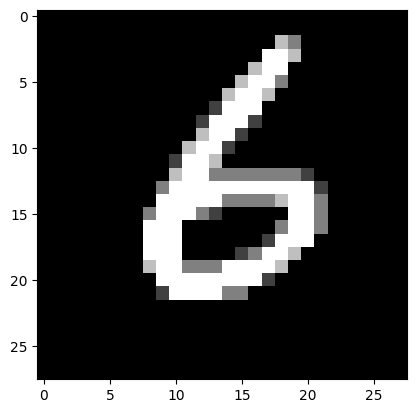

In [81]:
plt.figure()
plt.imshow(train_images[66], cmap = 'gist_gray')
plt.show()

In [82]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

(60000, 28, 28, 1)


In [83]:
# нормализация данных
train_images = (train_images - 127.5) / 127.5
# Размер входного шума
NOISE_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# размер первого слоя
init_h = 7
init_w = 7
init_f = 256


In [84]:
def make_G():
    model = Sequential(name='generator')

    # полносвязный слой
    # (100, 1 , 1) => (7, 7, 256)
    model.add(layers.Dense(init_h * init_w * init_f, input_dim=NOISE_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((init_h, init_w, init_f)))
    # (7, 7, 256) => (14, 141 2560)
    model.add(layers.Conv2DTranspose(init_f //2, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))
    # (14, 14, 256) => (28, 28, 128)
    model.add(layers.Conv2DTranspose(init_f // 4, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))
    # (28, 28, 128) => (28, 28, 1)
    model.add(layers.Conv2D(1, (5, 5), padding="same", activation="tanh"))
    return model



In [85]:
G = make_G()
G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 12544)             1266944   
                                                                 
 batch_normalization_27 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 re_lu_15 (ReLU)             (None, 12544)             0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 14, 14, 128)       819328    
 Transpose)                                                      
                                                                 
 batch_normalization_28 (Ba  (None, 14, 14, 128)       51

In [86]:
def make_D():
   model = Sequential(name='disciminator')
   # (28, 28, 1) => (14, 14, 64)
   model.add(layers.Conv2D(init_f// 4, (5, 5), strides=(2, 2), padding="same",
       input_shape=(28, 28, 1)))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

  #  (14, 14, 64) => (7, 7, 128)
   model.add(layers.Conv2D(init_f // 2, (5, 5), strides=(2, 2), padding="same"))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

    # (7, 7, 128) => (7 * 7 * 128, 1, 1)
   model.add(layers.Flatten())
   # (7 * 7 * 128, 1, 1) => (1, 1, 1)
   model.add(layers.Dense(1, activation="sigmoid"))
   return model

In [87]:
D = make_D()
D.summary()


Model: "disciminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_30 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_31 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)        

In [88]:

batch_size = 32

In [89]:
class DCGAN(keras.Model):
    def __init__(self, D, G, noise_dim):
        super().__init__()
        self.D = D
        self.G = G
        self.noise_dim = noise_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):


        noise = tf.random.normal(shape=(batch_size, self.noise_dim))

        #реальные изображения  отмечены единицей, фейковые нулем
        with tf.GradientTape() as tape:
            # потери на реальных изображениях
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)),
                                       self.D(real_images, training=True))

            # потери на фейковых изображениях
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)),
                                       self.D(self.G(noise), training=True))


            d_loss = (d_loss_real + d_loss_fake)
        # улучшаем весы дискриминатора
        grads = tape.gradient(d_loss, self.D.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.D.trainable_variables))


        # генератор хочет чтобы фейковые изображения воспинимались дискриминатор как настоящие
        with tf.GradientTape() as tape:
            g_loss = self.loss_fn(tf.ones((batch_size, 1)) , self.D(self.G(noise, training=True), training=True))
        # улучшаем весы генератора
        grads = tape.gradient(g_loss, self.G.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.G.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [90]:
# эту часть кода я нашел в интернете, она нужна только чтобы выводить промежуточные данные между эпохами

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, noise_dim=100):
        self.num_img = num_img
        self.noise_dim = noise_dim


        self.seed = tf.random.normal([16, noise_dim])

    def on_epoch_end(self, epoch, logs=None):

        generated_images = self.model.G(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.G.save('G.h5')


In [91]:

dcgan = DCGAN(D=D, G=G, noise_dim=NOISE_DIM)

In [92]:
dcgan.compile(
   d_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5),
   g_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5),
   loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
   5/1875 [..............................] - ETA: 52s - d_loss: 1.7522 - g_loss: 1.0958

1873/1875 [============================>.] - ETA: 0s - d_loss: 0.5731 - g_loss: 1.1511

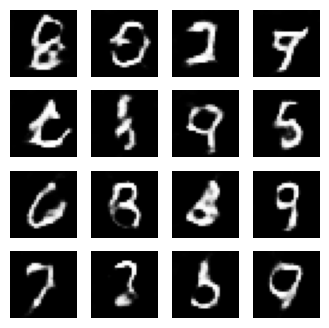

1875/1875 [==============================] - 36s 17ms/step - d_loss: 0.5737 - g_loss: 1.1511
Epoch 2/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.1203 - g_loss: 1.0876

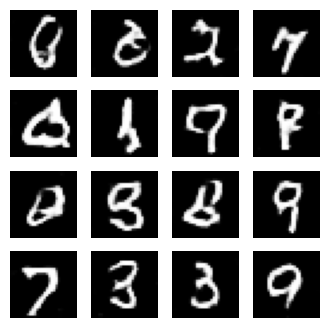

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.1205 - g_loss: 1.0873
Epoch 3/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.2095 - g_loss: 1.0072

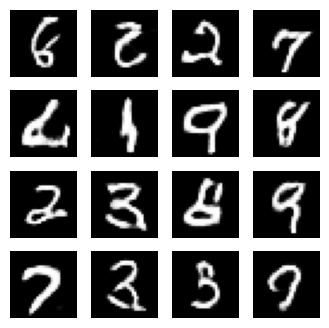

1875/1875 [==============================] - 31s 16ms/step - d_loss: 1.2096 - g_loss: 1.0071
Epoch 4/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.2546 - g_loss: 0.9553

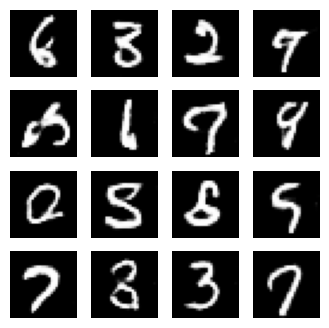

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.2546 - g_loss: 0.9553
Epoch 5/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 1.2846 - g_loss: 0.9217

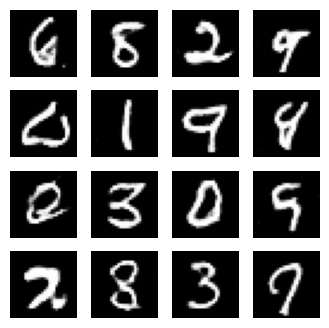

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.2847 - g_loss: 0.9216
Epoch 6/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 1.3040 - g_loss: 0.9002

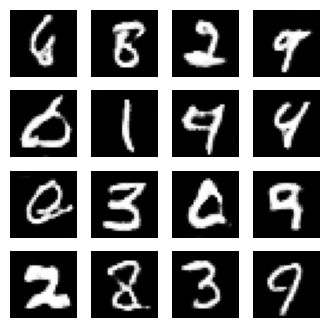

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3040 - g_loss: 0.9002
Epoch 7/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3243 - g_loss: 0.8785

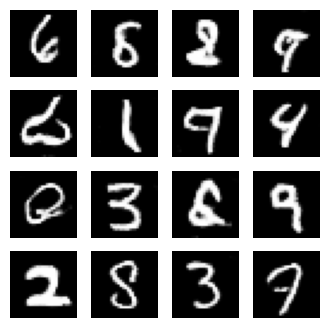

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3243 - g_loss: 0.8785
Epoch 8/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 1.3410 - g_loss: 0.8397

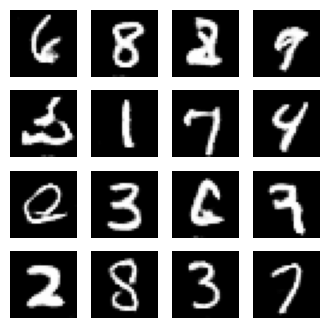

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3409 - g_loss: 0.8396
Epoch 9/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3521 - g_loss: 0.8338

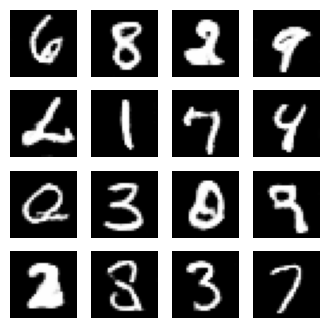

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3522 - g_loss: 0.8338
Epoch 10/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3600 - g_loss: 0.8146

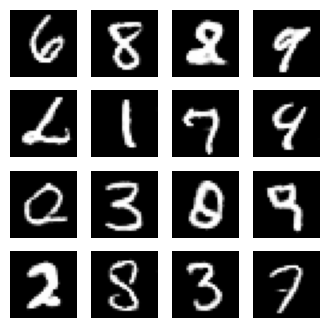

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3600 - g_loss: 0.8145
Epoch 11/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3666 - g_loss: 0.8090

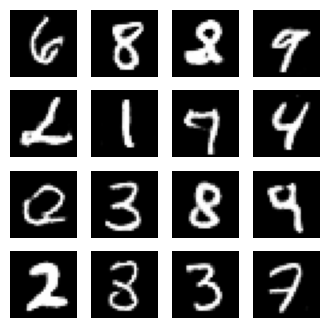

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3666 - g_loss: 0.8090
Epoch 12/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3687 - g_loss: 0.8017

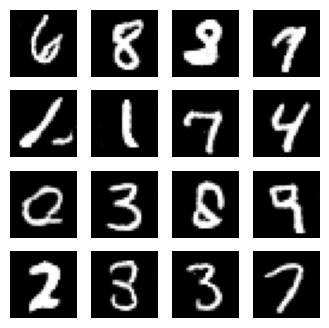

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3689 - g_loss: 0.8015
Epoch 13/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3708 - g_loss: 0.7929

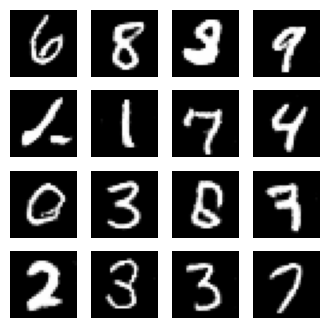

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3707 - g_loss: 0.7929
Epoch 14/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3734 - g_loss: 0.7891

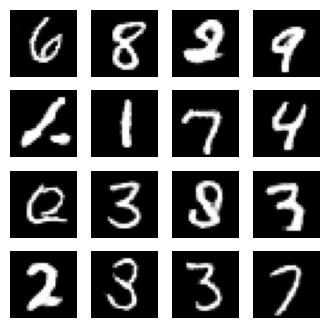

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3733 - g_loss: 0.7893
Epoch 15/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3744 - g_loss: 0.7844

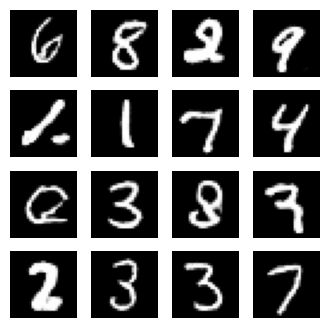

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3744 - g_loss: 0.7844
Epoch 16/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3759 - g_loss: 0.7857

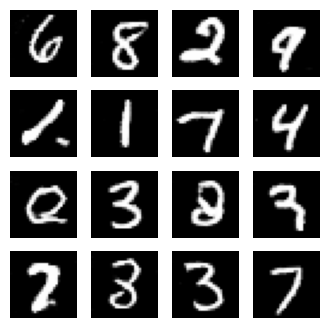

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3759 - g_loss: 0.7858
Epoch 17/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3776 - g_loss: 0.7803

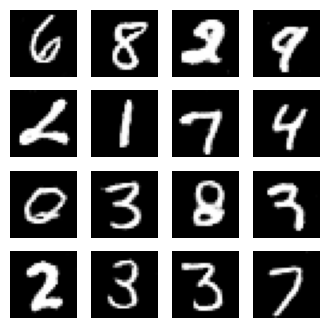

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3776 - g_loss: 0.7803
Epoch 18/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3760 - g_loss: 0.7777

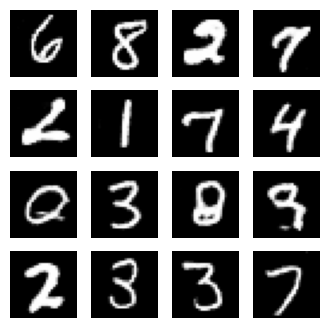

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3760 - g_loss: 0.7777
Epoch 19/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3777 - g_loss: 0.7768

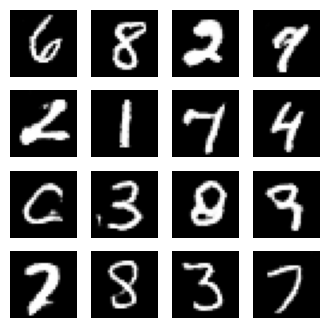

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3778 - g_loss: 0.7768
Epoch 20/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3783 - g_loss: 0.7707

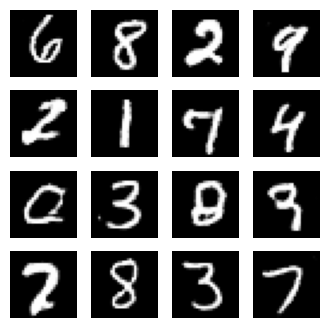

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3781 - g_loss: 0.7707
Epoch 21/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 1.3778 - g_loss: 0.7722

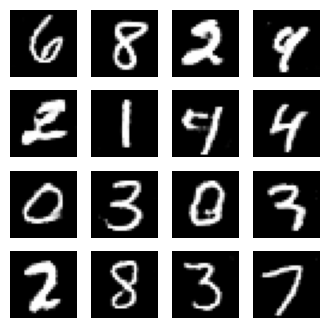

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3777 - g_loss: 0.7723
Epoch 22/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3805 - g_loss: 0.7686

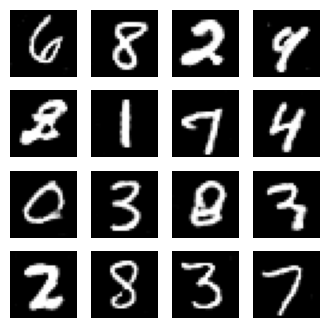

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3805 - g_loss: 0.7686
Epoch 23/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3810 - g_loss: 0.7662

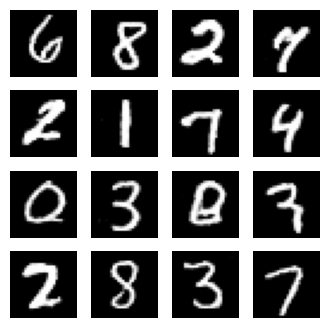

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3809 - g_loss: 0.7662
Epoch 24/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3809 - g_loss: 0.7635

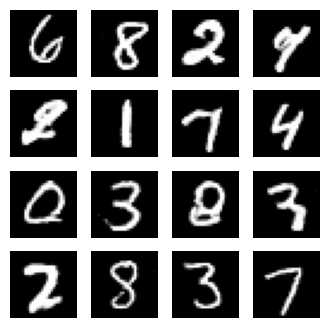

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3809 - g_loss: 0.7635
Epoch 25/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3826 - g_loss: 0.7615

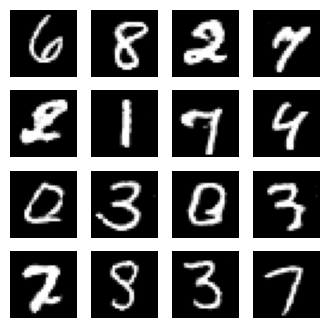

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3827 - g_loss: 0.7614
Epoch 26/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3833 - g_loss: 0.7613

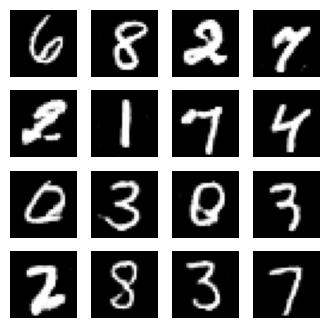

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3833 - g_loss: 0.7613
Epoch 27/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3837 - g_loss: 0.7583

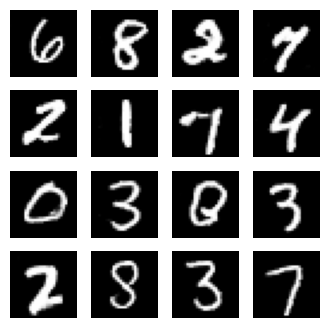

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3837 - g_loss: 0.7583
Epoch 28/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3839 - g_loss: 0.7560

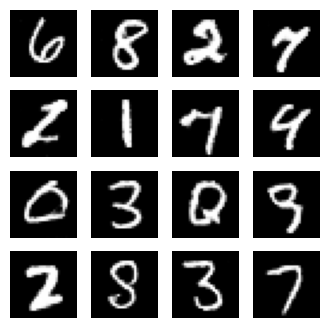

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3839 - g_loss: 0.7560
Epoch 29/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3832 - g_loss: 0.7565

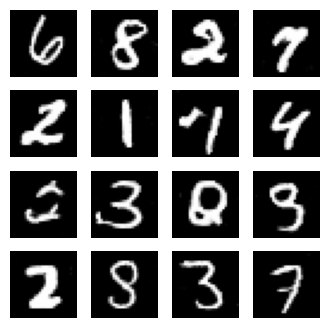

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3831 - g_loss: 0.7565
Epoch 30/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3831 - g_loss: 0.7546

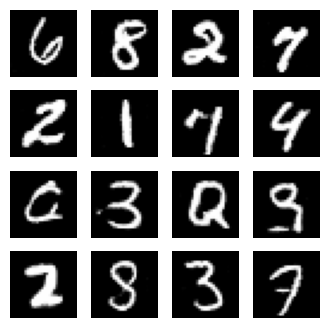

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3831 - g_loss: 0.7546
Epoch 31/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3832 - g_loss: 0.7536

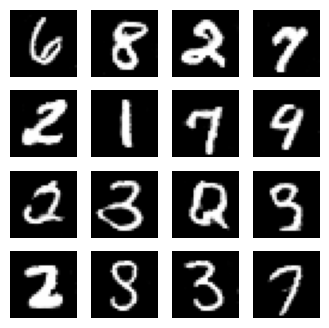

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3832 - g_loss: 0.7536
Epoch 32/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3830 - g_loss: 0.7546

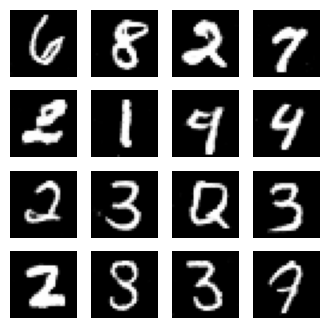

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3830 - g_loss: 0.7546
Epoch 33/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3835 - g_loss: 0.7521

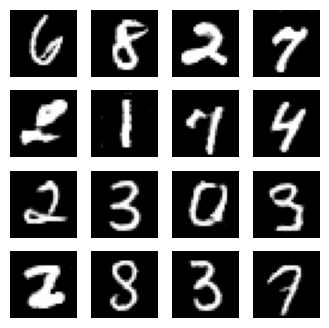

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3835 - g_loss: 0.7521
Epoch 34/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3822 - g_loss: 0.7520

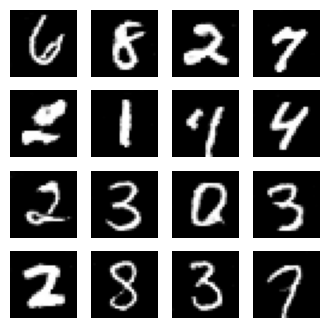

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3822 - g_loss: 0.7521
Epoch 35/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3825 - g_loss: 0.7518

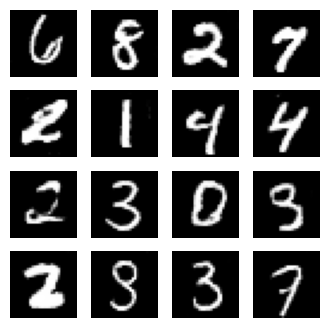

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3825 - g_loss: 0.7518
Epoch 36/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3840 - g_loss: 0.7492

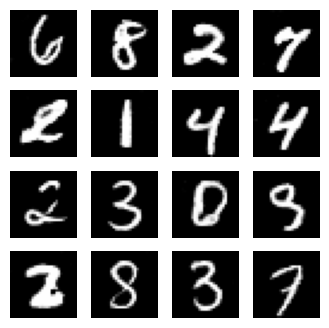

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3840 - g_loss: 0.7492
Epoch 37/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3822 - g_loss: 0.7494

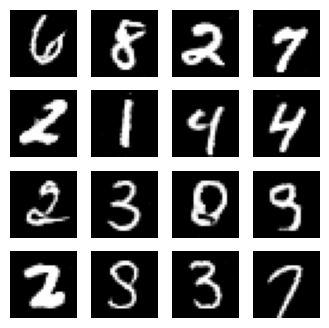

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3822 - g_loss: 0.7494
Epoch 38/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3808 - g_loss: 0.7494

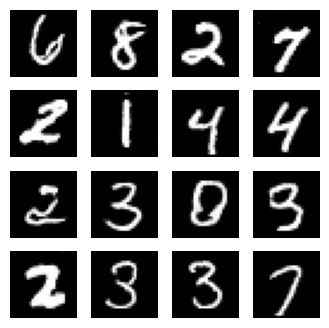

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3807 - g_loss: 0.7495
Epoch 39/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3829 - g_loss: 0.7489

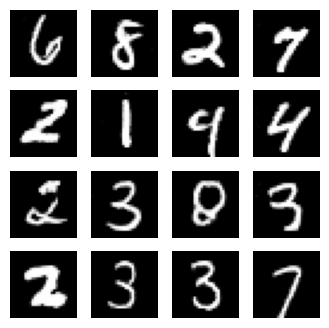

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3829 - g_loss: 0.7490
Epoch 40/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3821 - g_loss: 0.7472

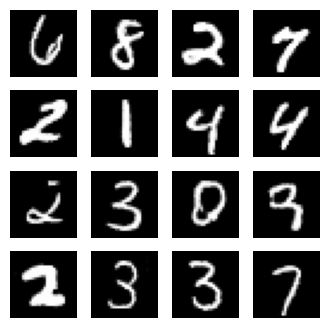

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3821 - g_loss: 0.7473
Epoch 41/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3813 - g_loss: 0.7464

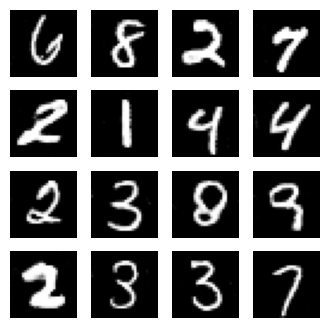

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3813 - g_loss: 0.7464
Epoch 42/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3842 - g_loss: 0.7442

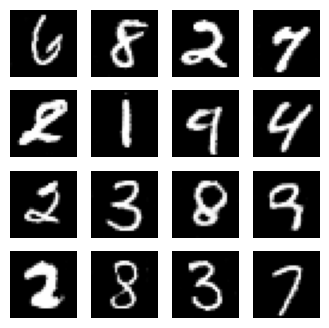

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3842 - g_loss: 0.7442
Epoch 43/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 1.3820 - g_loss: 0.7452

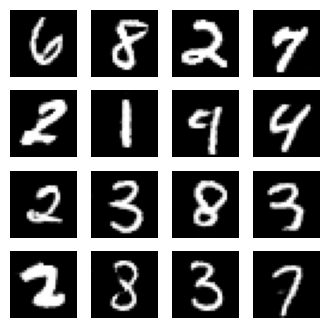

1875/1875 [==============================] - 33s 17ms/step - d_loss: 1.3820 - g_loss: 0.7452
Epoch 44/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3815 - g_loss: 0.7457

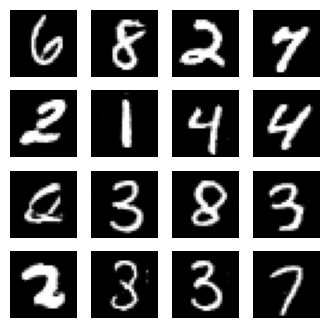

1875/1875 [==============================] - 31s 17ms/step - d_loss: 1.3814 - g_loss: 0.7457
Epoch 45/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3810 - g_loss: 0.7456

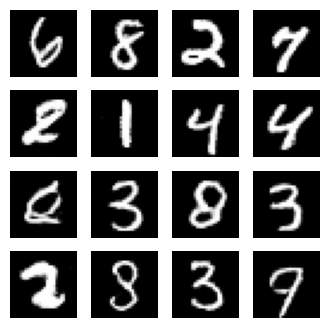

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3810 - g_loss: 0.7456
Epoch 46/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3801 - g_loss: 0.7447

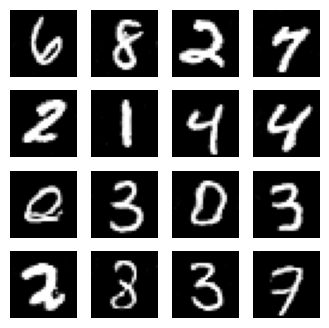

1875/1875 [==============================] - 33s 17ms/step - d_loss: 1.3801 - g_loss: 0.7447
Epoch 47/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3804 - g_loss: 0.7454

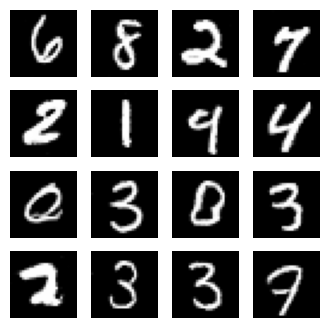

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3804 - g_loss: 0.7454
Epoch 48/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 1.3806 - g_loss: 0.7451

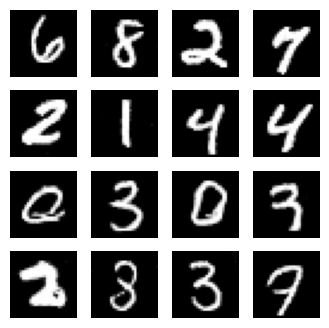

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3806 - g_loss: 0.7451
Epoch 49/50
1875/1875 [==============================] - ETA: 0s - d_loss: 1.3809 - g_loss: 0.7428

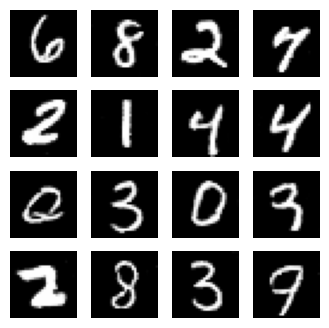

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3809 - g_loss: 0.7428
Epoch 50/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 1.3795 - g_loss: 0.7444

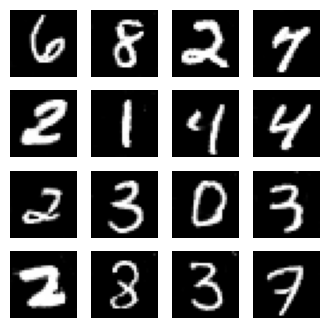

1875/1875 [==============================] - 32s 17ms/step - d_loss: 1.3795 - g_loss: 0.7444


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [93]:
NUM_EPOCHS = 50
dcgan.fit(train_images, epochs=NUM_EPOCHS,
callbacks=[GANMonitor(num_img=16, noise_dim=NOISE_DIM)])